In [2]:
import pandas as pd

df = pd.read_csv("/home/hp/results/HUMAN/distance_analysis_data.csv")
print("Columns in the CSV:", df.columns.tolist())

Columns in the CSV: ['Mutation', 'Mean_dG_star', 'Mean_dG0', 'dG_star_raw', 'dG0_raw', 'Level', 'sec49_distance', 'ca_distance']


In [5]:
# Quick check to count levels in your dataset
import pandas as pd

def check_levels(csv_path):
    """Quick function to check how many levels are in the dataset"""
    df = pd.read_csv(csv_path)
    
    # Clean Level column (same logic as in your main code)
    if 'Level' in df.columns:
        df['Level'] = df['Level'].astype(str)
        
        def extract_level_number(level_str):
            if level_str.startswith('level'):
                return int(level_str.replace('level', ''))
            else:
                try:
                    return int(float(level_str))
                except ValueError:
                    return 0
        
        df['Level'] = df['Level'].apply(extract_level_number)
        
        unique_levels = sorted(df['Level'].unique())
        print(f"Number of unique levels: {len(unique_levels)}")
        print(f"Level range: {min(unique_levels)} to {max(unique_levels)}")
        print(f"All levels: {unique_levels}")
        
        return len(unique_levels), unique_levels
    else:
        print("No 'Level' column found in the dataset")
        return 0, []

# Usage:
csv_path = "/home/hp/results/HUMAN/distance_analysis_data.csv"
num_levels, all_levels = check_levels(csv_path)

Number of unique levels: 19
Level range: 0 to 18
All levels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]


Creating HUMAN analysis with MOUSE PATTERN D plot and larger fonts...
- Using mouse pattern for Panel D (horizontal bars with L: and B: labels)
- Increased font sizes throughout
- Levels displayed as 0,1,2,...,18
Loaded data with shape: (273, 8)
Columns: ['Mutation', 'Mean_dG_star', 'Mean_dG0', 'dG_star_raw', 'dG0_raw', 'Level', 'sec49_distance', 'ca_distance']
After removing NaN values: (190, 8)
Level column cleaned. Range: 0 to 19
Expected 19 levels (0-18): False
Unique levels found: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]
Found 19 mutations that occur at multiple levels


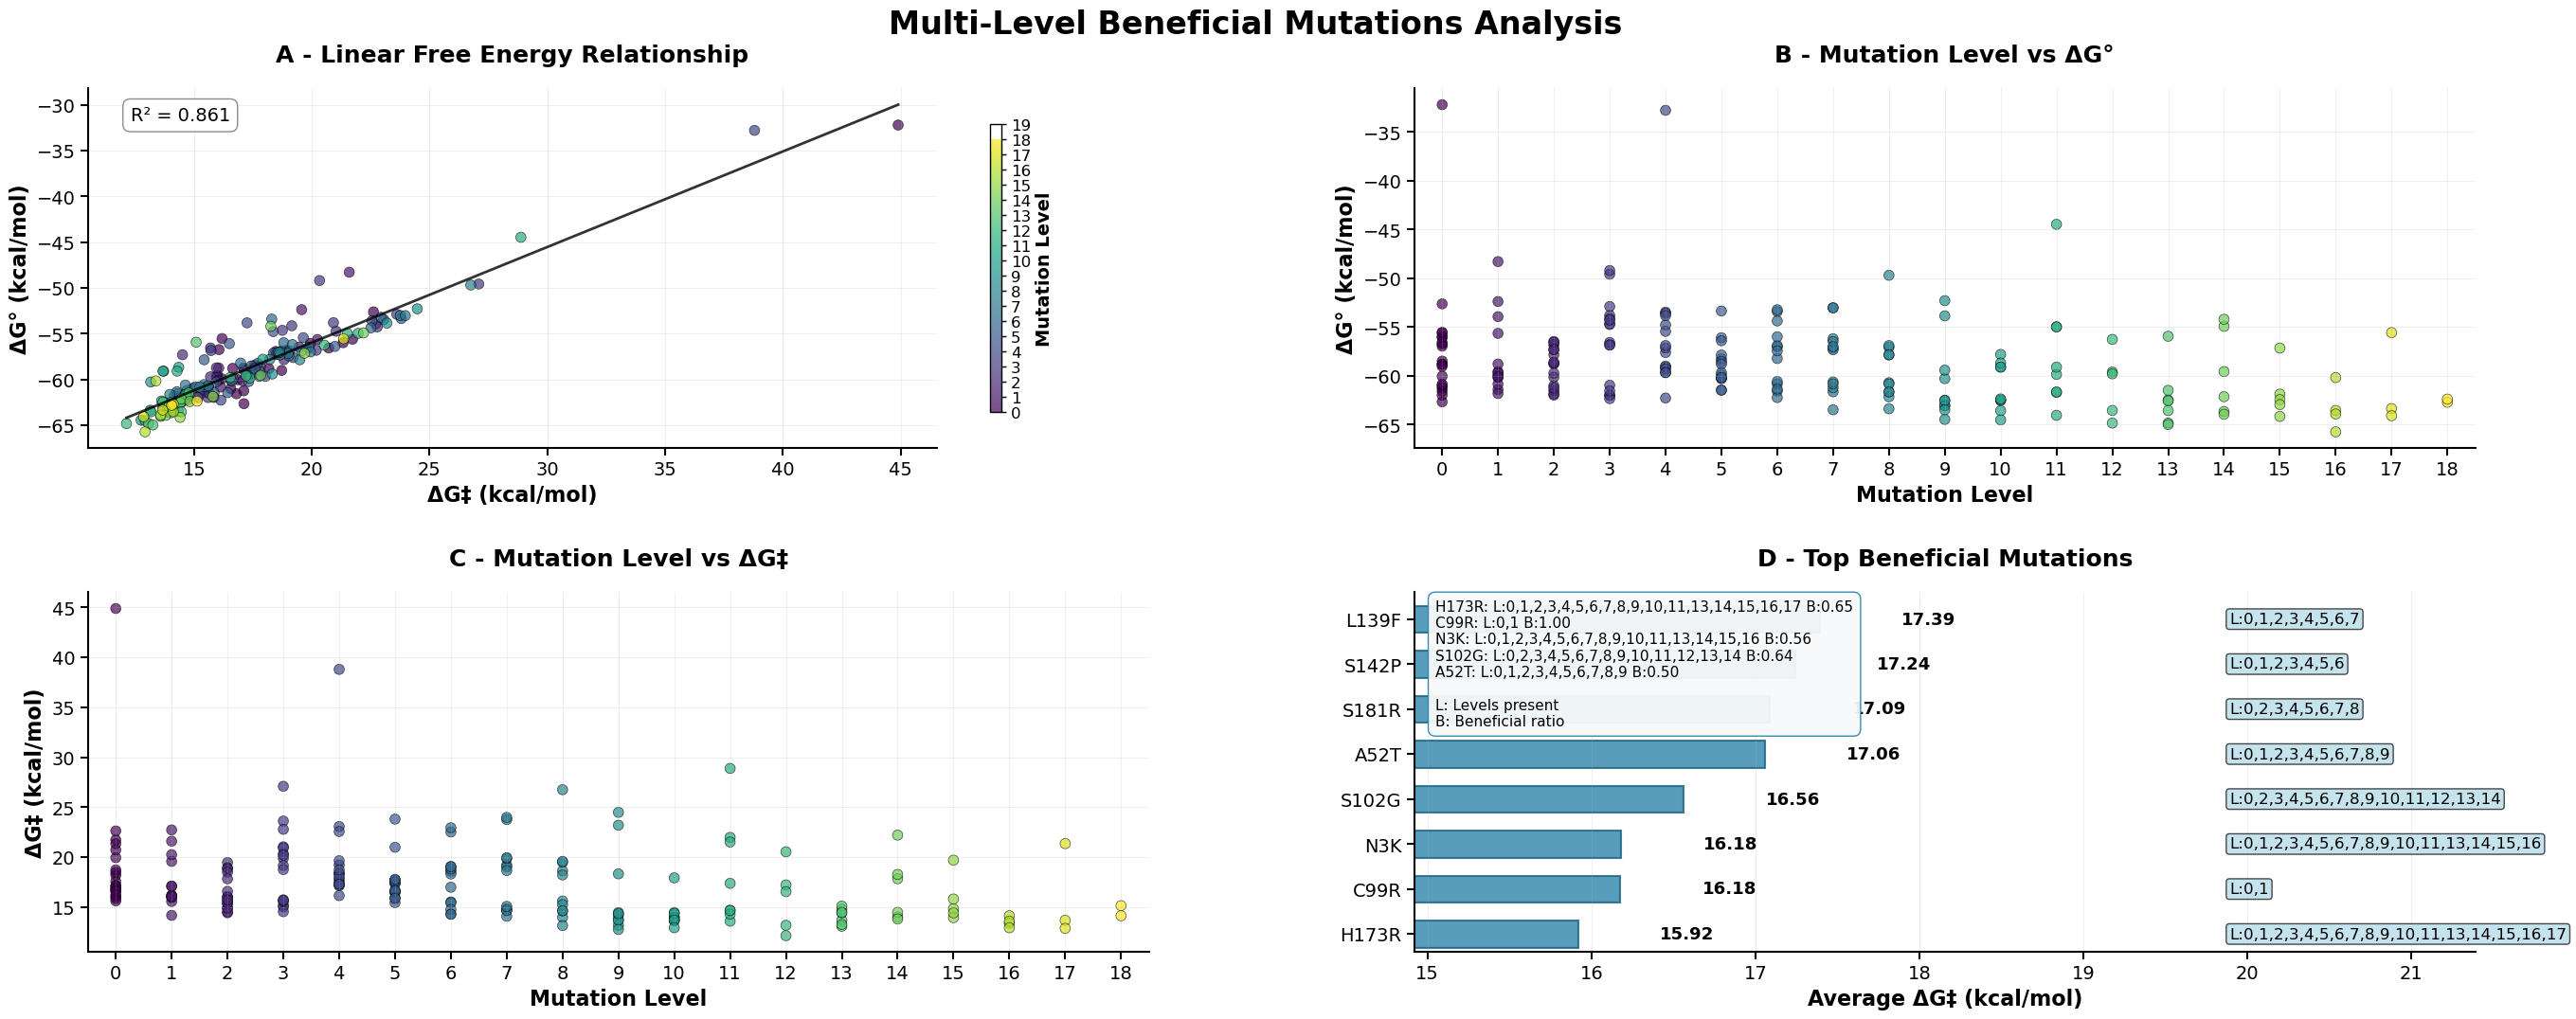


BENEFICIAL MUTATION ANALYSIS SUMMARY
Total mutations analyzed: 190
Mutations at multiple levels: 19
Beneficial mutations identified: 11

Top 8 beneficial mutations (displayed in plot):
 1. H173R        | Levels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17] | Avg ΔG‡:  15.92 | Ratio: 0.65
 2. C99R         | Levels: [0, 1] | Avg ΔG‡:  16.18 | Ratio: 1.00
 3. N3K          | Levels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16] | Avg ΔG‡:  16.18 | Ratio: 0.56
 4. S102G        | Levels: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] | Avg ΔG‡:  16.56 | Ratio: 0.64
 5. A52T         | Levels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] | Avg ΔG‡:  17.06 | Ratio: 0.50
 6. S181R        | Levels: [0, 2, 3, 4, 5, 6, 7, 8] | Avg ΔG‡:  17.09 | Ratio: 0.75
 7. S142P        | Levels: [0, 1, 2, 3, 4, 5, 6] | Avg ΔG‡:  17.24 | Ratio: 0.71
 8. L139F        | Levels: [0, 1, 2, 3, 4, 5, 6, 7] | Avg ΔG‡:  17.39 | Ratio: 0.50
✓ Human analysis with mouse pattern created successfully!
  - Panel D 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns
import matplotlib.font_manager as fm
from scipy import stats

def normalize_data(data):
    """
    Normalize data to 0-1 range using min-max normalization
    Replaces sklearn's MinMaxScaler
    
    Parameters:
    -----------
    data : numpy.ndarray
        Data to normalize
    
    Returns:
    --------
    numpy.ndarray
        Normalized data with values between 0 and 1
    """
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    
    # Avoid division by zero
    data_range = data_max - data_min
    data_range[data_range == 0] = 1
    
    return (data - data_min) / data_range

def check_arial_font():
    """Check if Arial font is available and provide installation guidance"""
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    arial_variants = ['Arial', 'Arial Unicode MS', 'Arial Black']
    
    arial_available = any(font in available_fonts for font in arial_variants)
    
    if not arial_available:
        return False
    else:
        return True

def setup_plos_style():
    """Configure matplotlib for PLOS ONE journal standards with LARGER fonts"""
    # Check Arial availability first
    arial_available = check_arial_font()
    
    # Set font family with fallbacks
    if arial_available:
        rcParams['font.family'] = 'Arial'
    else:
        # Use best available alternative
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        fallback_fonts = ['DejaVu Sans', 'Liberation Sans', 'Helvetica', 'sans-serif']
        
        for font in fallback_fonts:
            if font in available_fonts:
                rcParams['font.family'] = font
                break
        else:
            rcParams['font.family'] = 'sans-serif'
    
    # INCREASED font sizes for better readability
    rcParams['font.size'] = 14              # Increased from 12
    rcParams['axes.labelsize'] = 16         # Increased from 14
    rcParams['axes.titlesize'] = 18         # Increased from 16
    rcParams['xtick.labelsize'] = 14        # Increased from 12
    rcParams['ytick.labelsize'] = 14        # Increased from 12
    rcParams['legend.fontsize'] = 14        # Increased from 12
    rcParams['figure.titlesize'] = 22       # Increased from 18
    rcParams['axes.linewidth'] = 1.0
    rcParams['xtick.major.width'] = 1.0
    rcParams['ytick.major.width'] = 1.0
    rcParams['xtick.minor.width'] = 0.5
    rcParams['ytick.minor.width'] = 0.5
    rcParams['savefig.dpi'] = 300
    rcParams['savefig.bbox'] = 'tight'
    rcParams['savefig.pad_inches'] = 0.1

def clean_level_column(df):
    """
    Clean and convert Level column to integers
    Handles both 'level0' format and integer formats
    OPTIMIZED for 19 levels (0-18)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with Level column to clean
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with cleaned Level column as integers
    """
    if 'Level' not in df.columns:
        raise ValueError("Level column not found in DataFrame")
    
    # Convert Level column to string first to handle mixed types
    df['Level'] = df['Level'].astype(str)
    
    # Extract numeric part from level strings
    def extract_level_number(level_str):
        if level_str.startswith('level'):
            # Extract number after 'level'
            return int(level_str.replace('level', ''))
        else:
            # Try to convert directly to int
            try:
                return int(float(level_str))  # Handle float strings
            except ValueError:
                print(f"Warning: Could not parse level '{level_str}', setting to 0")
                return 0
    
    df['Level'] = df['Level'].apply(extract_level_number)
    
    # Validate that all levels are in expected range 0-18
    unique_levels = sorted(df['Level'].unique())
    expected_levels = list(range(19))  # 0 to 18
    
    print(f"Level column cleaned. Range: {df['Level'].min()} to {df['Level'].max()}")
    print(f"Expected 19 levels (0-18): {len(unique_levels) == 19}")
    print(f"Unique levels found: {unique_levels}")
    
    # Check for any unexpected levels
    unexpected_levels = [level for level in unique_levels if level not in expected_levels]
    if unexpected_levels:
        print(f"WARNING: Found unexpected levels: {unexpected_levels}")
    
    missing_levels = [level for level in expected_levels if level not in unique_levels]
    if missing_levels:
        print(f"INFO: Missing levels in data: {missing_levels}")
    
    return df

def analyze_beneficial_mutations(df_sorted):
    """
    Analyze beneficial mutations - MOUSE PATTERN APPROACH
    Those that occur across multiple levels with consistently lower ΔG‡
    
    Parameters:
    -----------
    df_sorted : pandas.DataFrame
        Sorted dataframe with mutation data
        
    Returns:
    --------
    dict : Dictionary containing beneficial mutation analysis
    """
    results = {}
    
    # Find mutations that occur at multiple levels (MOUSE PATTERN)
    mutation_level_counts = df_sorted.groupby('mutation')['Level'].nunique()
    multi_level_mutations = mutation_level_counts[mutation_level_counts > 1].index.tolist()
    
    print(f"Found {len(multi_level_mutations)} mutations that occur at multiple levels")
    
    # For mutations at multiple levels, check if they consistently have lower ΔG‡ (MOUSE PATTERN)
    beneficial_mutations = []
    mutation_analysis = {}
    
    # Calculate median ΔG‡ for each level to use as reference (MOUSE PATTERN)
    level_medians = df_sorted.groupby('Level')['dg_star'].median()
    
    for mutation in multi_level_mutations:
        mutation_data = df_sorted[df_sorted['mutation'] == mutation].copy()
        
        # Check if this mutation has lower ΔG‡ than median at each level it appears (MOUSE PATTERN)
        beneficial_at_levels = []
        total_levels = []
        
        for _, row in mutation_data.iterrows():
            level = row['Level']
            dg_star = row['dg_star']
            level_median = level_medians[level]
            
            total_levels.append(level)
            if dg_star < level_median:  # Lower (more favorable) ΔG‡
                beneficial_at_levels.append(level)
        
        # Consider beneficial if it's better than median at majority of levels where it appears (MOUSE PATTERN)
        beneficial_ratio = len(beneficial_at_levels) / len(total_levels)
        
        mutation_analysis[mutation] = {
            'levels_present': sorted(total_levels),
            'levels_beneficial': sorted(beneficial_at_levels),
            'beneficial_ratio': beneficial_ratio,
            'avg_dg_star': mutation_data['dg_star'].mean(),
            'avg_dg0': mutation_data['dg0'].mean(),
            'level_count': len(total_levels)
        }
        
        # Consider it beneficial if it's better than median at ≥50% of levels (MOUSE PATTERN)
        if beneficial_ratio >= 0.5:
            beneficial_mutations.append(mutation)
    
    # Sort beneficial mutations by average ΔG‡ (most favorable first) (MOUSE PATTERN)
    beneficial_mutations.sort(key=lambda x: mutation_analysis[x]['avg_dg_star'])
    
    results = {
        'multi_level_mutations': multi_level_mutations,
        'beneficial_mutations': beneficial_mutations,
        'mutation_analysis': mutation_analysis,
        'level_medians': level_medians
    }
    
    return results

def create_plos_analysis_mouse_pattern(csv_path):
    """
    Create PLOS ONE compliant figure with MOUSE PATTERN D plot and LARGER fonts
    Displays levels as 0,1,2,...,18
    
    Parameters:
    -----------
    csv_path : str
        Path to CSV file containing mutation data
    """
    
    # Setup PLOS ONE styling with larger fonts
    setup_plos_style()
    
    # Load and validate data
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded data with shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
    except FileNotFoundError:
        raise FileNotFoundError(f"Could not find file: {csv_path}")
    
    # Standardize column names
    column_mapping = {
        'Mean_dG_star': 'dg_star',
        'Mean_dG0': 'dg0', 
        'Mutation': 'mutation',
        'mean_dg_star': 'dg_star',
        'mean_dg0': 'dg0'
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df = df.rename(columns={old_name: new_name})
    
    # Validate required columns
    required_cols = {'dg_star', 'dg0', 'mutation', 'Level'}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Clean and sort data
    df = df.dropna(subset=list(required_cols))
    print(f"After removing NaN values: {df.shape}")
    
    # Clean Level column for 19 levels
    df = clean_level_column(df)
    
    df_sorted = df.sort_values('Level').reset_index(drop=True)
    
    # Analyze beneficial mutations using MOUSE PATTERN
    beneficial_analysis = analyze_beneficial_mutations(df_sorted)
    
    # Create figure with larger size and increased fonts
    fig = plt.figure(figsize=(28, 12), facecolor='white')
    
    # Create grid layout
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1.2, 1.2],
                         hspace=0.4, wspace=0.25, left=0.06, right=0.96, 
                         top=0.88, bottom=0.12)
    
    # Main plots
    ax1 = fig.add_subplot(gs[0, 0])  # LFER plot
    ax2 = fig.add_subplot(gs[0, 1])  # Level vs dG0
    ax3 = fig.add_subplot(gs[1, 0])  # Level vs dG_star
    ax4 = fig.add_subplot(gs[1, 1])  # MOUSE PATTERN beneficial mutations plot
    
    # Panel A: Linear Free Energy Relationship (LFER)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_sorted['dg_star'], df_sorted['dg0'])
    
    # Enhanced scatter plot with better color mapping for 19 levels
    scatter = ax1.scatter(df_sorted['dg_star'], df_sorted['dg0'],
                         c=df_sorted['Level'], s=60, alpha=0.7, 
                         edgecolors='black', linewidth=0.5,
                         cmap='viridis', vmin=0, vmax=18)  # Fixed range 0-18
    
    # Add colorbar with larger fonts
    cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8, aspect=25, pad=0.05)
    cbar.set_label('Mutation Level', fontweight='bold', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    # Set discrete ticks for levels - show all levels 0,1,2,...,18
    unique_levels = sorted(df_sorted['Level'].unique())
    cbar.set_ticks(unique_levels)
    
    # Add LFER line
    x_range = np.array([df_sorted['dg_star'].min(), df_sorted['dg_star'].max()])
    y_pred = slope * x_range + intercept
    ax1.plot(x_range, y_pred, 'k-', alpha=0.8, linewidth=2)
    
    # Add R² annotation with larger font
    ax1.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax1.transAxes,
             fontsize=14, verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, 
             edgecolor='gray', linewidth=1))
    
    ax1.set_xlabel('ΔG‡ (kcal/mol)', fontweight='bold', fontsize=16)
    ax1.set_ylabel('ΔG° (kcal/mol)', fontweight='bold', fontsize=16)
    ax1.set_title('A - Linear Free Energy Relationship', fontweight='bold', fontsize=18, pad=20)
    ax1.grid(True, alpha=0.3, linewidth=0.5)
    
    # Panel B: Level vs ΔG° - show levels as 0,1,2,...,18
    scatter2 = ax2.scatter(df_sorted['Level'], df_sorted['dg0'],
                          c=df_sorted['Level'], s=60, alpha=0.7,
                          edgecolors='black', linewidth=0.5,
                          cmap='viridis', vmin=0, vmax=18)
    
    # Set x-axis to show all levels 0,1,2,...,18
    all_levels = list(range(19))
    ax2.set_xticks(all_levels)
    ax2.set_xticklabels([str(i) for i in all_levels], fontsize=12)
    ax2.set_xlabel('Mutation Level', fontweight='bold', fontsize=16)
    ax2.set_ylabel('ΔG° (kcal/mol)', fontweight='bold', fontsize=16)
    ax2.set_title('B - Mutation Level vs ΔG°', fontweight='bold', fontsize=18, pad=20)
    ax2.grid(True, alpha=0.3, linewidth=0.5)
    ax2.set_xlim(-0.5, 18.5)
    
    # Panel C: Level vs ΔG‡ - show levels as 0,1,2,...,18
    scatter3 = ax3.scatter(df_sorted['Level'], df_sorted['dg_star'],
                          c=df_sorted['Level'], s=60, alpha=0.7,
                          edgecolors='black', linewidth=0.5,
                          cmap='viridis', vmin=0, vmax=18)
    
    ax3.set_xticks(all_levels)
    ax3.set_xticklabels([str(i) for i in all_levels], fontsize=12)
    ax3.set_xlabel('Mutation Level', fontweight='bold', fontsize=16)
    ax3.set_ylabel('ΔG‡ (kcal/mol)', fontweight='bold', fontsize=16)
    ax3.set_title('C - Mutation Level vs ΔG‡', fontweight='bold', fontsize=18, pad=20)
    ax3.grid(True, alpha=0.3, linewidth=0.5)
    ax3.set_xlim(-0.5, 18.5)
    
    # Panel D: MOUSE PATTERN bar plot with proper legend and level numbers
    beneficial_mutations = beneficial_analysis['beneficial_mutations']
    mutation_analysis = beneficial_analysis['mutation_analysis']
    
    if len(beneficial_mutations) > 0:
        # Limit to top 8 mutations for better readability (MOUSE PATTERN)
        display_mutations = beneficial_mutations[:8]
        avg_dg_star_values = [mutation_analysis[mut]['avg_dg_star'] for mut in display_mutations]
        
        # Create horizontal bar plot with PLENTY of spacing (MOUSE PATTERN)
        y_positions = np.arange(len(display_mutations)) * 2.5  # Large spacing
        bars = ax4.barh(y_positions, avg_dg_star_values, height=1.5,  # Thinner bars
                       color='#2E86AB', alpha=0.8, edgecolor='#1B5E7F', linewidth=1.5)
        
        # Clean mutation names for y-tick labels (MOUSE PATTERN)
        y_labels = []
        for mut in display_mutations:
            # Clean up mutation name - keep first 10 characters
            clean_name = mut[:10] if len(mut) <= 10 else mut[:8] + '..'
            y_labels.append(clean_name)
        
        ax4.set_yticks(y_positions)
        ax4.set_yticklabels(y_labels, fontsize=13)  # Increased font size
        ax4.set_xlabel('Average ΔG‡ (kcal/mol)', fontweight='bold', fontsize=16)
        ax4.set_title('D - Top Beneficial Mutations', fontweight='bold', fontsize=18, pad=20)
        ax4.grid(True, alpha=0.3, axis='x', linewidth=0.5)
        
        # Add value labels on the RIGHT side of each bar (MOUSE PATTERN)
        for i, (bar, value) in enumerate(zip(bars, avg_dg_star_values)):
            width = bar.get_width()
            y_pos = bar.get_y() + bar.get_height()/2
            
            # Value positioned well to the right of the bar
            ax4.text(width + 0.5, y_pos, f'{value:.2f}', 
                    ha='left', va='center', fontsize=13, fontweight='bold')  # Increased font size
        
        # Add level numbers on the far right side of each bar (MOUSE PATTERN)
        for i, mut in enumerate(display_mutations):
            analysis = mutation_analysis[mut]
            levels_str = ','.join(map(str, analysis['levels_present']))
            y_pos = y_positions[i]
            
            # Position level numbers even further to the right
            max_width = max(avg_dg_star_values)
            ax4.text(max_width + 2.5, y_pos, f'L:{levels_str}', 
                    ha='left', va='center', fontsize=12,  # Increased font size
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))
        
        # Set axis limits with proper spacing for level numbers
        ax4.set_ylim(-1, max(y_positions) + 1.5)
        x_min = min(avg_dg_star_values) - 1
        x_max = max(avg_dg_star_values) + 4  # Extra space for level numbers
        ax4.set_xlim(x_min, x_max)
        
        # Add legend with PROPER L and B prefixes (MOUSE PATTERN)
        legend_entries = []
        for mut in display_mutations[:5]:  # Show details for top 5
            analysis = mutation_analysis[mut]
            levels_str = ','.join(map(str, analysis['levels_present']))
            ratio = analysis['beneficial_ratio']
            # Add the L and B prefixes
            legend_entries.append(f"{mut[:8]}: L:{levels_str} B:{ratio:.2f}")
        
        legend_text = "\n".join(legend_entries)
        legend_text += "\n\nL: Levels present\nB: Beneficial ratio"
        
        # Position legend in empty space with larger font
        ax4.text(0.02, 0.98, legend_text, 
                transform=ax4.transAxes, va='top', ha='left', fontsize=11,  # Increased font size
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#f8f9fa', alpha=0.95, 
                         edgecolor='#2E86AB', linewidth=1))
        
    else:
        ax4.text(0.5, 0.5, 'No beneficial mutations\nmeeting criteria found', 
                transform=ax4.transAxes, ha='center', va='center', fontsize=16,  # Increased font size
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffe6e6', alpha=0.8))
        ax4.set_title('D - Beneficial Mutations', fontweight='bold', fontsize=18, pad=20)
    
    # Clean up all axes - remove top and right spines
    for ax in [ax1, ax2, ax3, ax4]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.tick_params(axis='both', which='major', labelsize=14, width=1.5, length=6)  # Increased font size
        ax.tick_params(axis='both', which='minor', labelsize=12, width=1, length=3)   # Increased font size
    
    # Add main figure title with proper spacing and larger font
    fig.suptitle('Multi-Level Beneficial Mutations Analysis', 
                 fontsize=24, fontweight='bold', y=0.95)  # Increased font size
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("BENEFICIAL MUTATION ANALYSIS SUMMARY")
    print("="*80)
    print(f"Total mutations analyzed: {len(df_sorted)}")
    print(f"Mutations at multiple levels: {len(beneficial_analysis['multi_level_mutations'])}")
    print(f"Beneficial mutations identified: {len(beneficial_mutations)}")
    
    if len(beneficial_mutations) > 0:
        print(f"\nTop 8 beneficial mutations (displayed in plot):")
        for i, mut in enumerate(beneficial_mutations[:8], 1):
            analysis = mutation_analysis[mut]
            print(f"{i:2d}. {mut:<12} | Levels: {analysis['levels_present']} | "
                  f"Avg ΔG‡: {analysis['avg_dg_star']:6.2f} | Ratio: {analysis['beneficial_ratio']:.2f}")
    
    return fig, (ax1, ax2, ax3, ax4), beneficial_analysis

# Main function
def main():
    """Main function with MOUSE PATTERN D plot and larger fonts"""
    csv_path = "/home/hp/results/HUMAN/distance_analysis_data.csv"
    
    print("Creating HUMAN analysis with MOUSE PATTERN D plot and larger fonts...")
    print("- Using mouse pattern for Panel D (horizontal bars with L: and B: labels)")
    print("- Increased font sizes throughout")
    print("- Levels displayed as 0,1,2,...,18")
    
    try:
        fig, axes, beneficial_analysis = create_plos_analysis_mouse_pattern(csv_path)
        print("✓ Human analysis with mouse pattern created successfully!")
        print("  - Panel D follows mouse pattern exactly")
        print("  - All font sizes increased for better readability")
        print("  - Levels properly displayed as 0,1,2,...,18")
        print("  - Legend shows L: (levels) and B: (beneficial ratio)")
            
    except Exception as e:
        print(f"Error: {e}")
        print("Please check your CSV file path and column names.")

if __name__ == "__main__":
    main()